<a href="https://colab.research.google.com/github/Ahnkyuwon504/AI-modeling/blob/main/BX-gpt-app/gemma_ko_2b_rag_chunking_CBP_certi_legacy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 라이브러리 설치

In [57]:
!pip install -q datasets pandas pymongo sentence_transformers
!pip install -q -U transformers
!pip install -q accelerate
!pip install -q "pymongo[srv]"
!pip install -q -U bitsandbytes
!pip install -q PyPDF2 openparse
!pip install -q langchain langchain_experimental langchain_openai
!pip install -q unstructured > /dev/null

# 2. Dataset

## CBP certi manual pdf파일 로드 / chunking

In [51]:
embedding_model = 'text-embedding-3-large'
# test_doc = '/content/drive/MyDrive/AI-modeling/BX-gpt-app/22-BX-CBP-상품컴포넌트.md'
test_doc = '/content/drive/MyDrive/AI-modeling/BX-gpt-app/CBP 상품.pdf'

In [52]:
from openparse import processing, DocumentParser
from google.colab import userdata

semantic_pipeline = processing.SemanticIngestionPipeline(
    openai_api_key= userdata.get('OPENAI_API_KEY'),
    model=embedding_model,
    min_tokens=64,
    max_tokens=1024,
)
parser = DocumentParser(
    processing_pipeline=semantic_pipeline,
)

parsed_content = parser.parse(test_doc)

In [4]:
parsed_content

ParsedDocument(id_='f383e78b-8936-4785-bb17-517c933f4289', nodes=[Node(id_='39387846-b45d-4c0f-9a89-a749e50bad9c', elements=(TextElement(text='**학습범위**', lines=(LineElement(bbox=(38.25, 679.71, 116.25, 699.21), spans=(TextSpan(text='학습범위 ', is_bold=True, is_italic=False, size=19.5),), style=None, text='**학습범위**'),), bbox=Bbox(page=0, page_height=841.91998, page_width=594.95996, x0=38.25, y0=679.71, x1=116.25, y1=699.21), variant=<NodeVariant.TEXT: 'text'>, embed_text='**학습범위**'), TextElement(text='베이스컴포넌트-PD ', lines=(LineElement(bbox=(38.25, 653.56, 123.06, 663.31), spans=(TextSpan(text='베이스컴포넌트-PD ', is_bold=False, is_italic=False, size=9.75),), style=None, text='베이스컴포넌트-PD '),), bbox=Bbox(page=0, page_height=841.91998, page_width=594.95996, x0=38.25, y0=653.56, x1=123.06, y1=663.31), variant=<NodeVariant.TEXT: 'text'>, embed_text='베이스컴포넌트-PD '), TextElement(text='**과정목표**', lines=(LineElement(bbox=(38.25, 602.46, 116.25, 621.96), spans=(TextSpan(text='과정목표 ', is_bold=True, is_italic

In [5]:
all_text = []
for node in parsed_content.nodes:
    for element in node.elements:
      print(element.embed_text, '\n')

**학습범위** 

베이스컴포넌트-PD  

**과정목표** 

1. 베이스컴포넌트 PD 의 역할을 이해한다  

2. PD 에서 제공하는 API 기능을 이해한다  

3. API를 이용하여 서비스 구현을 할 수 있다  

**1. 상품 베이스 컴포넌트 개요** 

**1.1. 상품 베이스 컴포넌트 Position** 

상품팩토리시스템은 CBP와는 별도의 시스템으로, 상품팩토리시스템에서 정의된 상품정보는 CBP시스템으로 배포되어  

**상품 베이스컴포넌트 Position** 

**BX Product Factory**
**상품팩토리시스템** 

**BX CBP**
**코어뱅킹 시스템** 

**상품정보배포** 

**상품**
**정보** 

**상품**
**정보** 

상품컴포넌트(상품 = ProDuct = PD)의 영문약어는 PD이며 아래의 R&R에 따라 기능을 제공한다.  

**기능/예시** 

- 정기예금 상품의 가입가능기간 조회  

- 보통예금 상품의 금리 조회  

상품의 특성 정보 조회  

- 정기예금 상품의 중도해지 금리 조회  

- 정기적금 상품의 상속가능여부 조회  

- 신용대출 상품의 기한연장이 가능한 횟수 조회  

상품의 기본 정보 조회 - 상품명, 판매기간, 판매가능여부  

판매가능 부서 조회  

- 상품을 특정 부서에서만 판매할 수 있는 경우 판매가능한 부서 조회  

상품의 금리 체계 조회 - 상품에 적용된 금리 체계 조회  

상품의 분류 정보 조회 - 상품을 다양한 관점으로 분류했을 때 어떻게 분류가 되는지 조회  

**1.3. 상품정보 유형** 

상품정보의 유형별로 관리되는 내용은 다음과 같다  

**의 유형** 

- 상품명, 상품 판매 기간, 상품 판매 가능여  

상품 기본  

- 상품의 기본 정보  

정보  

- 상품에서 사용하는 금리 체계 정보  

- 적금중도해지금리체계 : 중도해지이율 적  

- 신용대출 금리체계 : 기준금리 + 유동성프  

- 판매대상 고객군에 따른 수신 상품의 분류 

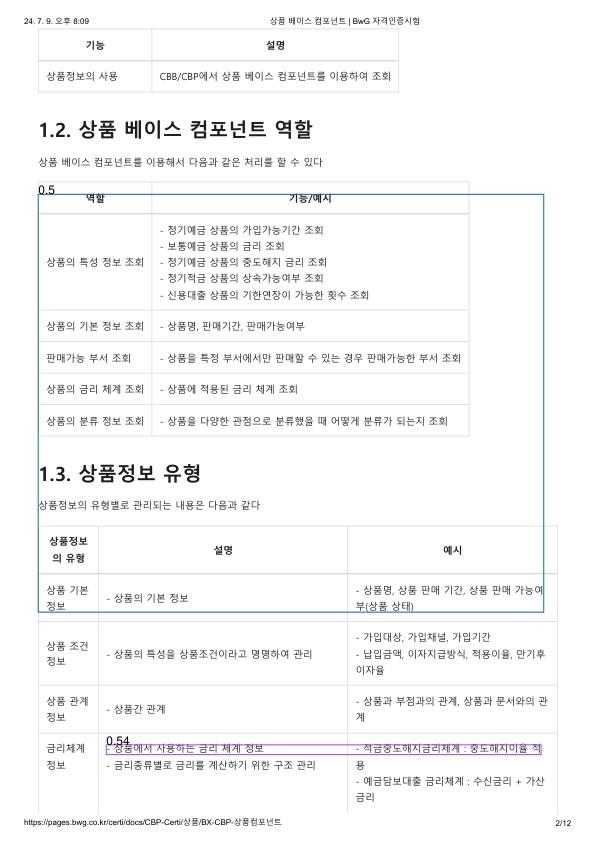

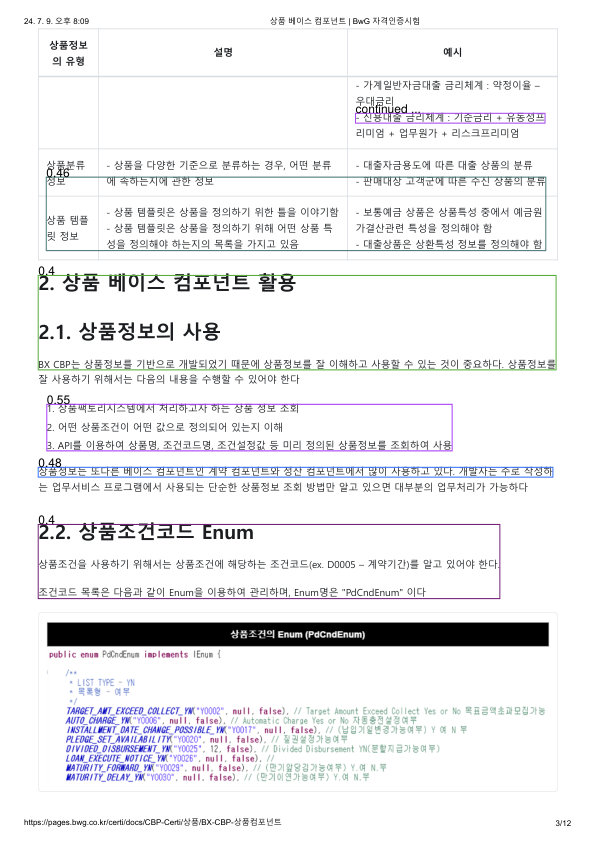

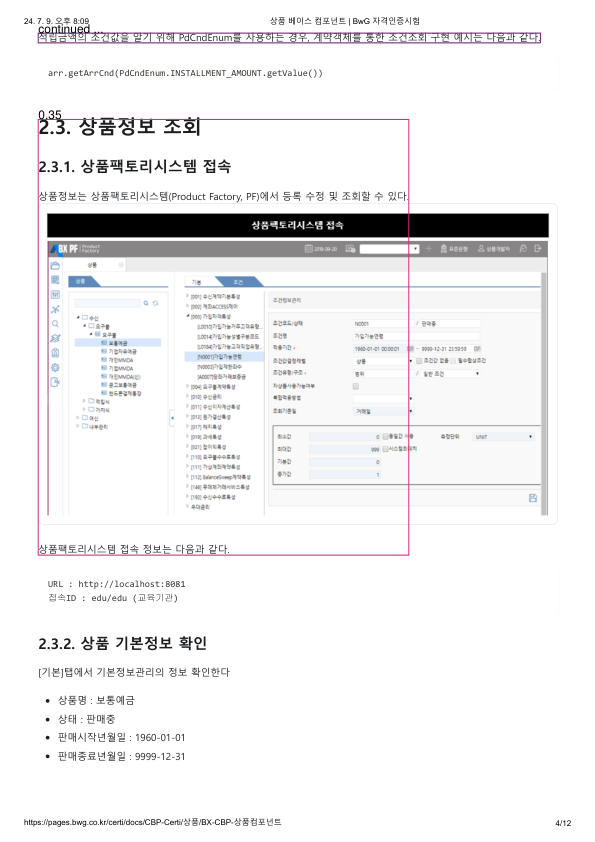

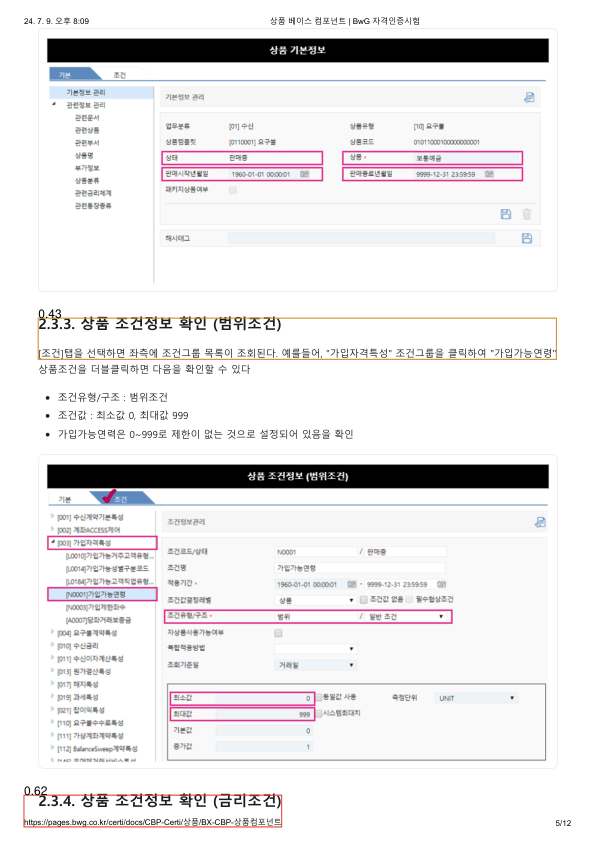

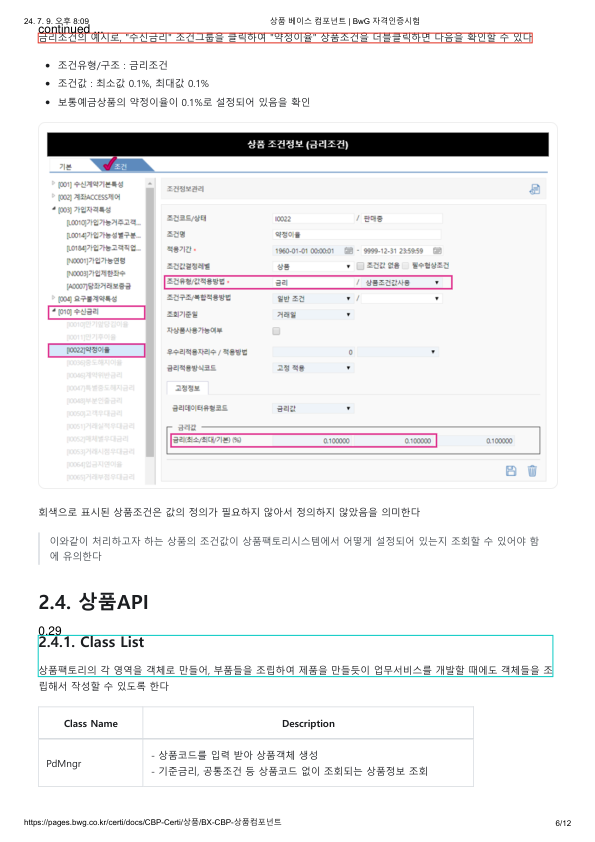

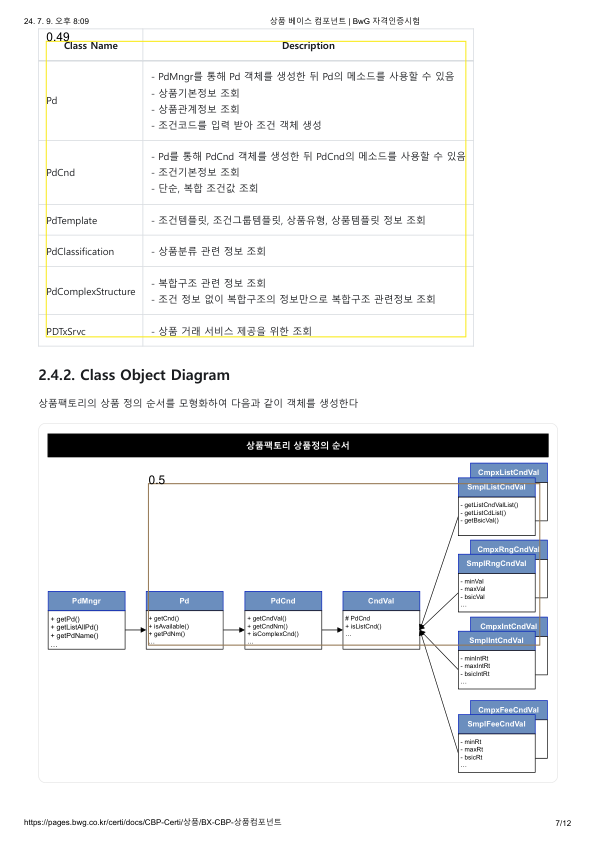

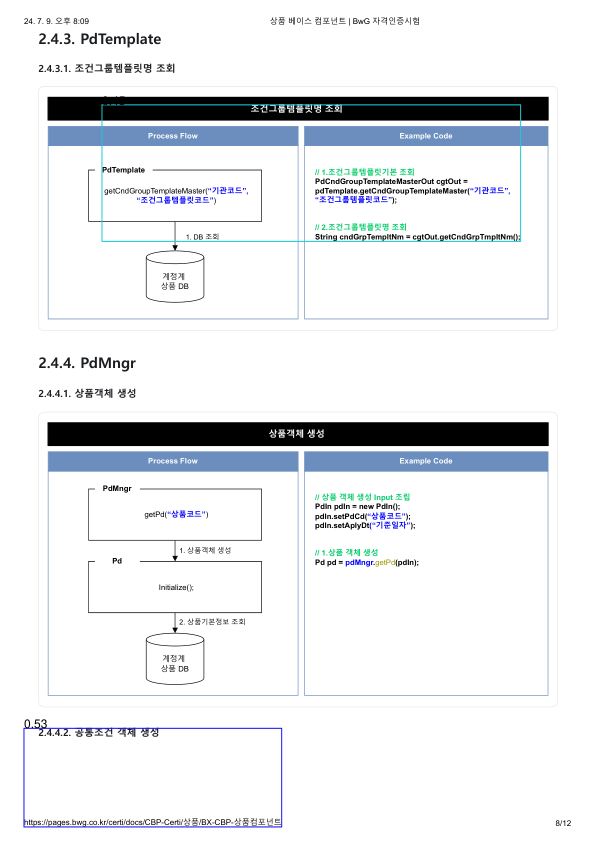

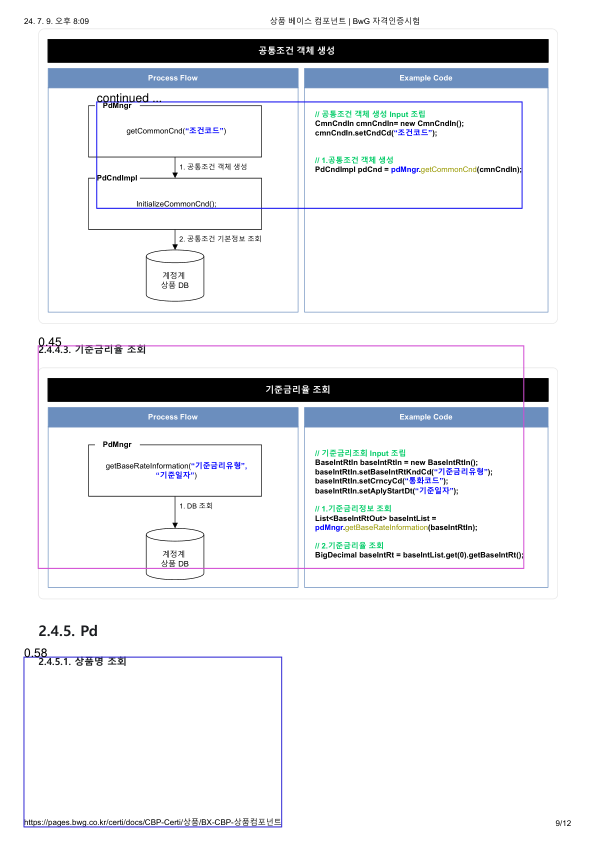

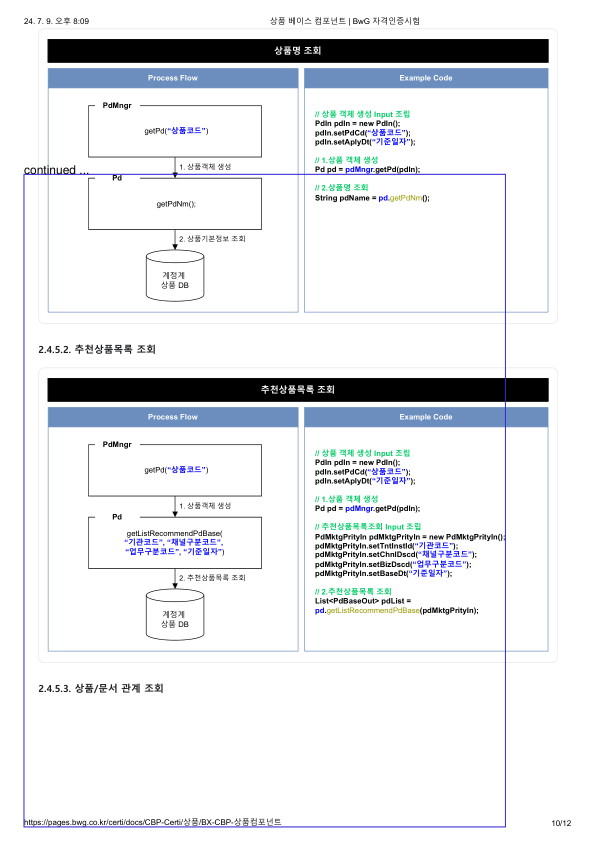

In [6]:
from openparse import Pdf, Node, processing
import numpy as np

embedding_client = processing.OpenAIEmbeddings(
    api_key=userdata.get('OPENAI_API_KEY'),
    model=embedding_model,
)

def cosine_similarity(
    a: np.ndarray | list[float], b: np.ndarray | list[float]
) -> float:
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def get_node_similarities(nodes: list[Node]):
    # get the similarity of each node with the node that precedes it
    embeddings = embedding_client.embed_many([node.text for node in nodes])
    similarities = []
    for i in range(1, len(embeddings)):
        similarities.append(cosine_similarity(embeddings[i - 1], embeddings[i]))

    similarities = [round(sim, 2) for sim in similarities]
    return [0] + similarities

doc = Pdf(file=test_doc)

annotations = get_node_similarities(parsed_content.nodes)
doc.display_with_bboxes(
    parsed_content.nodes,
    annotations=annotations,
    page_nums=list(range(1, 10)),
)

In [ ]:
import PyPDF2

pdf_files = [
    '/content/drive/MyDrive/AI-modeling/BX-gpt-app/BX-CBP 제품소개.pdf',
    # '/content/drive/MyDrive/AI-modeling/BX-gpt-app/BX-PF 제품소개.pdf',
    # '/content/drive/MyDrive/AI-modeling/BX-gpt-app/CBP 계약.pdf',
    # '/content/drive/MyDrive/AI-modeling/BX-gpt-app/CBP 공통.pdf',
    # '/content/drive/MyDrive/AI-modeling/BX-gpt-app/CBP 베이스.pdf',
    # '/content/drive/MyDrive/AI-modeling/BX-gpt-app/CBP 상품.pdf',
    # '/content/drive/MyDrive/AI-modeling/BX-gpt-app/CBP 아키텍처.pdf',
    # '/content/drive/MyDrive/AI-modeling/BX-gpt-app/CBP 액터.pdf',
    # '/content/drive/MyDrive/AI-modeling/BX-gpt-app/CBP 정산.pdf',
]

def extract_text_from_pdf(pdf_path):
    with open(pdf_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)

        pdf_text = ""
        for page_num in range(len(reader.pages)):
            page = reader.pages[page_num]
            pdf_text += page.extract_text()

    return pdf_text

def chunk_text(text, chunk_size=1000):
    chunks = []
    for i in range(0, len(text), chunk_size):
        chunks.append(text[i:i + chunk_size])
    return chunks

all_chunks = []
for pdf_file in pdf_files:
    print(f"Processing {pdf_file}...")
    pdf_text = extract_text_from_pdf(pdf_file)
    chunks = chunk_text(pdf_text, chunk_size=1000)
    all_chunks.extend(chunks)

for i, chunk in enumerate(all_chunks[:3]):
    print(f"Chunk {i+1}:\n{chunk}\n")

In [48]:
from pdfminer.high_level import extract_pages
from pdfminer.layout import LTTextContainer, LTChar, LTAnno

def extract_text_from_pdf(pdf_path):
    text = ""
    for page_layout in extract_pages(pdf_path):
        for element in page_layout:
           if isinstance(element, LTTextContainer):
                for text_line in element:
                    for character in text_line:
                        # LTChar는 실제 텍스트 문자를 나타내고, LTAnno는 공백이나 줄바꿈 등을 나타냅니다.
                        if isinstance(character, (LTChar, LTAnno)):
                            text += character.get_text()
    return text

# PDF에서 텍스트 추출
pdf_text = extract_text_from_pdf(test_doc)

# 텍스트 출력 (부분)
print(pdf_text[:100])

24. 7. 9. 오후 8:09
상품 베이스 컴포넌트 | BwG 자격인증시험
상품
상품 베이스 컴포넌트
Edit this page
Prologue
학습범위
베이스컴포넌트-PD
과정


In [42]:
from langchain.document_loaders import PyPDFLoader

loader = PyPDFLoader(test_doc)
# loader = DirectoryLoader(".", glob="data/*.pdf")

docs = loader.load()
print(f"pages: {len(docs)}")
print(f"\n[content]\n{docs[0].page_content[:1000]}")

pages: 12

[content]
상품 상품 베이스 컴포넌트
Prologue
학습범위
베이스컴포넌트-PD
과정목표
1. 베이스컴포넌트 PD 의 역할을 이해한다
2. PD 에서 제공하는 API 기능을 이해한다
3. API를 이용하여 서비스 구현을 할 수 있다
예상 학습 시간: 4 시간
1. 상품 베이스 컴포넌트 개요
1.1. 상품 베이스 컴포넌트 P osition
상품팩토리시스템은 CBP와는 별도의 시스템으로, 상품팩토리시스템에서 정의된 상품정보는 CBP시스템으로 배포되어
사용된다
상품 베이스컴포넌트  Position
BX Product Factory
상품팩토리시스템BX CBP
코어뱅킹  시스템
상품정보  정의CBB
PD(상품 ) 
베이스  컴포넌트정산
계약
상품
정보상품
정보CBS
상품정보배포상품정보제공
상품컴포넌트(상품 = Pr oDuct = PD)의 영문약어는 PD이며 아래의 R&R에 따라 기능을 제공한다.
기능 설명
상품의 정의 또는 수정 상품팩토리시스템에서 수행
Edit this p age24. 7. 9. 오후  8:09 상품 베이스  컴포넌트  | BwG 자격인증시험
https://pages.bwg.co.kr/certi/docs/CBP-Certi/ 상품 /BX-CBP- 상품컴포넌트 1/12


In [24]:
docs[0]

Document(metadata={'source': '/content/drive/MyDrive/AI-modeling/BX-gpt-app/CBP 상품.pdf', 'page': 0}, page_content='상품 상품 베이스 컴포넌트\nPrologue\n학습범위\n베이스컴포넌트-PD\n과정목표\n1. 베이스컴포넌트 PD 의 역할을 이해한다\n2. PD 에서 제공하는 API 기능을 이해한다\n3. API를 이용하여 서비스 구현을 할 수 있다\n예상 학습 시간: 4 시간\n1. 상품 베이스 컴포넌트 개요\n1.1. 상품 베이스 컴포넌트 P osition\n상품팩토리시스템은 CBP와는 별도의 시스템으로, 상품팩토리시스템에서 정의된 상품정보는 CBP시스템으로 배포되어\n사용된다\n상품 베이스컴포넌트  Position\nBX Product Factory\n상품팩토리시스템BX CBP\n코어뱅킹  시스템\n상품정보  정의CBB\nPD(상품 ) \n베이스  컴포넌트정산\n계약\n상품\n정보상품\n정보CBS\n상품정보배포상품정보제공\n상품컴포넌트(상품 = Pr oDuct = PD)의 영문약어는 PD이며 아래의 R&R에 따라 기능을 제공한다.\n기능 설명\n상품의 정의 또는\xa0수정 상품팩토리시스템에서 수행\nEdit this p age24. 7. 9. 오후  8:09 상품 베이스  컴포넌트  | BwG 자격인증시험\nhttps://pages.bwg.co.kr/certi/docs/CBP-Certi/ 상품 /BX-CBP- 상품컴포넌트 1/12')

In [76]:
loader = UnstructuredMarkdownLoader(test_doc_md, mode="elements")

data = loader.load()
print(f"Number of documents: {len(data)}\n")

for document in data[:77]:
    print(f"{document.page_content}\n")

Number of documents: 77

title : "상품 베이스 컴포넌트"

Prologue

본 교재는 CBP자격인증 중 CBP개발자 기본과정 취득을 위한 자율학습 교재이다.

학습범위

베이스컴포넌트-PD

과정목표

베이스컴포넌트 PD 의 역할을 이해한다

PD 에서 제공하는 API 기능을 이해한다

API를 이용하여 서비스 구현을 할 수 있다

예상 학습 시간: 4 시간

1. 상품 베이스 컴포넌트 개요

1.1. 상품 베이스 컴포넌트 Position

상품팩토리시스템은 CBP와는 별도의 시스템으로, 상품팩토리시스템에서 정의된 상품정보는 CBP시스템으로 배포되어 사용된다

상품컴포넌트(상품 = ProDuct = PD)의 영문약어는 PD이며 아래의 R&R에 따라 기능을 제공한다.

기능 설명 상품의 정의 또는 수정 상품팩토리시스템에서 수행 상품정보의 사용 CBB/CBP에서 상품 베이스 컴포넌트를 이용하여 조회

1.2. 상품 베이스 컴포넌트 역할

상품 베이스 컴포넌트를 이용해서 다음과 같은 처리를 할 수 있다

역할 기능/예시 상품의 특성 정보 조회 - 정기예금 상품의 가입가능기간 조회 - 보통예금 상품의 금리 조회 - 정기예금 상품의 중도해지 금리 조회 - 정기적금 상품의 상속가능여부 조회 - 신용대출 상품의 기한연장이 가능한 횟수 조회 상품의 기본 정보 조회 - 상품명, 판매기간, 판매가능여부 판매가능 부서 조회 - 상품을 특정 부서에서만 판매할 수 있는 경우 판매가능한 부서 조회 상품의 금리 체계 조회 - 상품에 적용된 금리 체계 조회 상품의 분류 정보 조회 - 상품을 다양한 관점으로 분류했을 때 어떻게 분류가 되는지 조회

1.3. 상품정보 유형

상품정보의 유형별로 관리되는 내용은 다음과 같다

상품정보의 유형 설명 예시 상품 기본 정보 - 상품의 기본 정보 - 상품명, 상품 판매 기간, 상품 판매 가능여부(상품 상태) 상품 조건 정보 - 상품의 특성을 상품조건이라고 명명하여 관리 - 가입대상, 가입채널, 가입기간 - 납입금액, 이자지

In [62]:
test_doc_md = '/content/drive/MyDrive/AI-modeling/BX-gpt-app/22-BX-CBP-상품컴포넌트.md'

In [79]:
from langchain_community.document_loaders import UnstructuredMarkdownLoader
from langchain_core.documents import Document

# 파일을 바이너리 모드로 읽고 디코딩
def read_file_with_encoding(file_path, encodings=['utf-8', 'latin-1', 'cp1252']):
    for encoding in encodings:
        try:
            with open(file_path, 'rb') as file:
                binary_data = file.read()
                return binary_data.decode(encoding)
        except UnicodeDecodeError as e:
            print(f"Failed to decode with encoding {encoding}: {e}")
    raise ValueError("Unable to decode the file with provided encodings.")

# 파일 읽기
markdown_text = read_file_with_encoding(test_doc_md)

data = [Document(page_content=markdown_text)]
print(data[0])
# readme_content = data[0].page_content
# print(readme_content[:10000])

page_content='---
title : "상품 베이스 컴포넌트"
---

# Prologue

본 교재는 CBP자격인증 중 CBP개발자 기본과정 취득을 위한 자율학습 교재이다.

## 학습범위

베이스컴포넌트-PD

## 과정목표

1. 베이스컴포넌트 PD 의 역할을 이해한다
2. PD 에서 제공하는 API 기능을 이해한다
3. API를 이용하여 서비스 구현을 할 수 있다

> 예상 학습 시간: 4 시간

# 1. 상품 베이스 컴포넌트 개요

## 1.1. 상품 베이스 컴포넌트 Position

상품팩토리시스템은 CBP와는 별도의 시스템으로, 상품팩토리시스템에서 정의된 상품정보는 CBP시스템으로 배포되어 사용된다

![PD베이스컴포넌트](../img/PD1.1.PD베이스컴포넌트.svg)

상품컴포넌트(상품 = ProDuct = PD)의 영문약어는 PD이며 아래의 R&R에 따라 기능을 제공한다.

| 기능                   | 설명                                             |
| ---------------------- | ------------------------------------------------ |
| 상품의 정의 또는 수정 | 상품팩토리시스템에서 수행                        |
| 상품정보의 사용        | CBB/CBP에서 상품 베이스 컴포넌트를 이용하여 조회 |

## 1.2. 상품 베이스 컴포넌트 역할

상품 베이스 컴포넌트를 이용해서 다음과 같은 처리를 할 수 있다

| 역할                  | 기능/예시                                                                                                                                                                                                 

In [92]:
import re

def remove_empty_lines(text):
    # 여러 개의 개행 문자를 하나의 개행 문자로 대체
    text = re.sub(r'\n\s*\n', '\n', text)
    return text

def remove_image_lines(text):
    # ![...](...svg) 또는 ![...](...png)로 끝나는 라인
    pattern_svg_jpg = r'^.*!\[.*?\]\(.*?\.(svg|png)\).*$'
    # single hash
    pattern_single_hash = r'^# .*$'
    cleaned_text = re.sub(pattern_svg_jpg, '', text, flags=re.MULTILINE)

    lines = cleaned_text.split('\n')
    cleaned_lines = [line for line in lines if not re.match(pattern_single_hash, line)]
    cleaned_text = '\n'.join(cleaned_lines)
    return cleaned_text

cleaned_text = remove_empty_lines(data[0].page_content)
cleaned_text = remove_image_lines(cleaned_text)
cleaned_text = remove_empty_lines(cleaned_text)
print(cleaned_text)

---
title : "상품 베이스 컴포넌트"
---
본 교재는 CBP자격인증 중 CBP개발자 기본과정 취득을 위한 자율학습 교재이다.
## 학습범위
베이스컴포넌트-PD
## 과정목표
1. 베이스컴포넌트 PD 의 역할을 이해한다
2. PD 에서 제공하는 API 기능을 이해한다
3. API를 이용하여 서비스 구현을 할 수 있다
> 예상 학습 시간: 4 시간
## 1.1. 상품 베이스 컴포넌트 Position
상품팩토리시스템은 CBP와는 별도의 시스템으로, 상품팩토리시스템에서 정의된 상품정보는 CBP시스템으로 배포되어 사용된다
상품컴포넌트(상품 = ProDuct = PD)의 영문약어는 PD이며 아래의 R&R에 따라 기능을 제공한다.
| 기능                   | 설명                                             |
| ---------------------- | ------------------------------------------------ |
| 상품의 정의 또는 수정 | 상품팩토리시스템에서 수행                        |
| 상품정보의 사용        | CBB/CBP에서 상품 베이스 컴포넌트를 이용하여 조회 |
## 1.2. 상품 베이스 컴포넌트 역할
상품 베이스 컴포넌트를 이용해서 다음과 같은 처리를 할 수 있다
| 역할                  | 기능/예시                                                                                                                                                                                                      |
| --------------------- | ---------------------------------------------------------------------

In [96]:
def chunk_by_double_hash(text):
    # ##을 기준으로 문서를 청킹
    pattern = r'(?<=\n)## .*(?=\n)'
    # 패턴을 기준으로 분할
    chunks = re.split(pattern, text)
    # 첫 번째 청크는 빈 문자열이 될 수 있으므로 제거
    if chunks[0].strip() == '':
        chunks = chunks[1:]
    return chunks

def remove_repeated_triple_hash(chunks):
    cleaned_chunks = []
    for chunk in chunks:
        lines = chunk.split('\n')
        cleaned_lines = []
        triple_hash_count = 0
        for line in lines:
            if line.startswith('###'):
                triple_hash_count += 1
                if triple_hash_count > 1:
                    continue  # 연속된 ### 라인이 5줄 이하인 경우 제거
            else:
                triple_hash_count = 0
            cleaned_lines.append(line)

        cleaned_chunks.append('\n'.join(cleaned_lines))
    return cleaned_chunks

chunks = chunk_by_double_hash(cleaned_text)
# ###이 5줄 이내로 반복되는 라인 제거
final_chunks = remove_repeated_triple_hash(chunks)

# 결과 출력
for i, chunk in enumerate(final_chunks):
    print(f"Chunk {i + 1}:")
    print(chunk.strip())  # 앞뒤 공백 제거
    print("===" * 20)

Chunk 1:
---
title : "상품 베이스 컴포넌트"
---
본 교재는 CBP자격인증 중 CBP개발자 기본과정 취득을 위한 자율학습 교재이다.
Chunk 2:
베이스컴포넌트-PD
Chunk 3:
1. 베이스컴포넌트 PD 의 역할을 이해한다
2. PD 에서 제공하는 API 기능을 이해한다
3. API를 이용하여 서비스 구현을 할 수 있다
> 예상 학습 시간: 4 시간
Chunk 4:
상품팩토리시스템은 CBP와는 별도의 시스템으로, 상품팩토리시스템에서 정의된 상품정보는 CBP시스템으로 배포되어 사용된다
상품컴포넌트(상품 = ProDuct = PD)의 영문약어는 PD이며 아래의 R&R에 따라 기능을 제공한다.
| 기능                   | 설명                                             |
| ---------------------- | ------------------------------------------------ |
| 상품의 정의 또는 수정 | 상품팩토리시스템에서 수행                        |
| 상품정보의 사용        | CBB/CBP에서 상품 베이스 컴포넌트를 이용하여 조회 |
Chunk 5:
상품 베이스 컴포넌트를 이용해서 다음과 같은 처리를 할 수 있다
| 역할                  | 기능/예시                                                                                                                                                                                                      |
| --------------------- | --------------------------------------------------------------------------------------------

In [86]:
from langchain_experimental.text_splitter import SemanticChunker
from langchain_openai.embeddings import OpenAIEmbeddings
from sentence_transformers import SentenceTransformer

semantic_text_splitter = SemanticChunker(
    OpenAIEmbeddings(openai_api_key=userdata.get('OPENAI_API_KEY')),
    breakpoint_threshold_type="interquartile",
)

cnt = 0

for sent in semantic_text_splitter.split_text(cleaned_text):
    print(sent)
    print("===" * 20)
    cnt += 1

print(cnt)

---
title : "상품 베이스 컴포넌트"
---

# Prologue

본 교재는 CBP자격인증 중 CBP개발자 기본과정 취득을 위한 자율학습 교재이다. ## 학습범위

베이스컴포넌트-PD

## 과정목표

1. 베이스컴포넌트 PD 의 역할을 이해한다
2. PD 에서 제공하는 API 기능을 이해한다
3. API를 이용하여 서비스 구현을 할 수 있다

> 예상 학습 시간: 4 시간

# 1. 상품 베이스 컴포넌트 개요

## 1.1. 상품 베이스 컴포넌트 Position

상품팩토리시스템은 CBP와는 별도의 시스템으로, 상품팩토리시스템에서 정의된 상품정보는 CBP시스템으로 배포되어 사용된다



상품컴포넌트(상품 = ProDuct = PD)의 영문약어는 PD이며 아래의 R&R에 따라 기능을 제공한다. | 기능                   | 설명                                             |
| ---------------------- | ------------------------------------------------ |
| 상품의 정의 또는 수정 | 상품팩토리시스템에서 수행                        |
| 상품정보의 사용        | CBB/CBP에서 상품 베이스 컴포넌트를 이용하여 조회 |

## 1.2. 상품 베이스 컴포넌트 역할

상품 베이스 컴포넌트를 이용해서 다음과 같은 처리를 할 수 있다

| 역할                  | 기능/예시                                                                                                                                                                                                      |
| --------------------- | -----------------------